In [1]:
# Import libraries
import re
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

import xgboost
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50000)

In [2]:
# Import data
df = pd.read_csv('data/dataset.csv')

In [3]:
# Employer Title

In [4]:
def emp_title(data, pattern, category_name):
    """
    Find patterns and return a list with the common category name for 
    different patterns. For eg: If 'Walmart' appears in the following 
    formats ('walmart', 'Wal-Mart', 'Walmart')
    """
    unique_names = data['emp_title'].unique() 
    matches = [pattern.findall(i) for i in unique_names if len(pattern.findall(i)) > 0]
    matches = [item for l in matches for item in l]
    return [category_name if i in matches else i for i in data['emp_title']]


def emp_title_patterns(data, col_name):
    """
    Identify and apply patterns of most common employer title and 
    replace the remaining with Others!!
    """
    
    # US Army
    pattern = re.compile(r'[a-zA-Z\S]*^[uU][a-zA-Z\s\S]+[Aa][Rr][Mm][Yy][a-zA-Z\S]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'U.S. Army')

    # US Navy
    pattern = re.compile(r'^[uU][a-zA-Z\s\S]+[Nn][Aa][Vv][Yy][a-zA-Z\S]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'U.S. Navy')

    # Walmart
    pattern = re.compile(r'^[Ww][Aa][a-zA-Z\S]+[tT]$[a-zA-Z\S]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'Walmart')

    # Banks
    pattern = re.compile(r'[a-zA-Z\S\s]*[Bb][Aa][Nn][Kk][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'Banks')

    # AT&T
    pattern = re.compile(r'[a-zA-Z\S\s]*[Aa][Tt][&n][Tt][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'AT&T')

    # Air Force
    pattern = re.compile(r'[a-zA-Z\S\s]*Force[a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'Air Force')

    # USPS
    pattern = re.compile(r'^[Uu][a-zA-Z\S\s]*[Pp][Oo][Ss][Tt][Aa][Ll][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'USPS')

    # USPS
    pattern = re.compile(r'^[Uu][Ss][Pp][Ss]')
    data.loc[:,col_name] = emp_title(data, pattern, 'USPS')

    # Chase Bank
    pattern = re.compile(r'[a-zA-Z\S\s]*[Cc]hase[a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'J.P. Morgan Chase')

    # IBM
    pattern = re.compile(r'[a-zA-Z\S\s]*[Ii][Bb][Mm][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'IBM')

    # University
    pattern = re.compile(r'[a-zA-Z\S\s]*[Uu][Nn][Ii][Vv][Ee][Rr][Ss][Ii][Tt][Yy][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'University')

    # Airlines
    pattern = re.compile(r'[a-zA-Z\S\s]*[Aa]irline[s]*[a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'Airlines')

    # The Home Depot
    pattern = re.compile(r'[a-zA-Z\S\s]*[Hh][Oo][Mm][Ee]\s[Dd][Ee][Pp][Oo][Tt][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'The Home Depot')

    # Other
    top_category = ['None', 'Banks', 'University', 'U.S. Army', 'Air Force', 'USPS', 'Airlines', 'Walmart', 'J.P. Morgan Chase', 'IBM', 'U.S. Navy', 'The Home Depot', 'AT&T']
    data.loc[:,col_name] = ['Other' if i not in top_category else i for i in data.loc[:,col_name]] 
    
    return data[col_name]

In [5]:
def lambda_nltk_notes(data, col_names):

    data.loc[:, col_names] = data[col_names].fillna('None')
    stop_words = stopwords.words('english')
    stop_words.append('br/')
    special_char = re.compile(r'[\W]')
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    sample = []
    for index, note in enumerate(data[col_names]):
        word_tokens = word_tokenize(note)
        no_stops = [i for i in word_tokens if i.lower() not in stop_words]
        no_special = [special_char.sub('',i) for i in no_stops if special_char.sub('',i) != '']
        stem_lemma = " ".join(ps.stem(lemmatizer.lemmatize(i.lower())) for i in no_special)
        sample.append(stem_lemma)

    return sample


In [6]:
# Apply Data Preprocessing

In [7]:
def data_preprocessiong(data):
    
    # emp_title - CATEGORICAL
    data.loc[:,'emp_title'] = data['emp_title'].fillna('None')
    data.loc[:,'emp_title'] = emp_title_patterns(data, 'emp_title')
    
    # emp_length - NUMERICAL
    data.loc[:,'emp_length'] = [0 if i == 'na' else i for i in data['emp_length']]
    data.loc[:,'emp_length'] = data['emp_length'].astype(int)
    
    # home_ownership - CATEGORICAL
    data.drop(data.loc[data['home_ownership']=='NONE', :].index, inplace=True)
    
    # annual_inc - NUMERICAL
    data.loc[:,'annual_inc'] = data['annual_inc'].fillna(0)
    
    # verification_status - CATEGORICAL
    
    # Notes - TEXT
    data.loc[:,'Notes'] = lambda_nltk_notes(data, 'Notes')
    data.loc[:,'Notes'] = data['Notes'].astype(str)
    
    # purpose_cat - CATEGORICAL
    purpose_df = pd.DataFrame(data['purpose_cat'].value_counts())
    purpose_df.reset_index(inplace=True) 
    other_small_business = list(purpose_df.loc[purpose_df['purpose_cat'] < 90, 'index'])
    data.loc[:,'purpose_cat'] = [i if i not in other_small_business else 'other small business' for i in data['purpose_cat']]
    
    # addr_state - CATEGORICAL
    
    # debt_to_income - NUMERICAL
    
    # delinq_2yrs - NUMERICAL
    data.loc[:,'delinq_2yrs'] = data['delinq_2yrs'].fillna(0.0)
    
    # earliest_cr_line - CATEGORICAL
    data.loc[:,'quarter'] = [str(i.quarter) for i in pd.to_datetime(data['earliest_cr_line'])]
    data.loc[:,'year'] = [str(i.year) for i in pd.to_datetime(data['earliest_cr_line'])]
    
    #### replace less frequent with 'Other' 
    cr_line_df = pd.DataFrame(data['year'].value_counts())
    cr_line_df.reset_index(inplace=True) 
    other_years = list(cr_line_df.loc[cr_line_df['year'] < 90, 'index'])
    data.loc[:,'year'] = [i if i not in other_years else 'other' for i in data['year']]

    # inq_last_6mths - NUMERICAL
    data.loc[:,'inq_last_6mths'] = data['inq_last_6mths'].fillna(0)
    
    # mths_since_last_delinq - NUMERICAL
    data.loc[:,'mths_since_last_delinq'] = data['mths_since_last_delinq'].fillna(0)
    
    # mths_since_last_record - NUMERICAL
    data.loc[:,'mths_since_last_record'] = data['mths_since_last_record'].fillna(0)
    
    # open_acc - NUMERICAL
    data.loc[:,'open_acc'] = data['open_acc'].fillna(data['open_acc'].mean())
    
    # pub_rec - NUMERICAL
    data.loc[:,'pub_rec'] = data['pub_rec'].fillna(0.0)
    
    # revol_bal - NUMERICAL
    
    # revol_util - NUMERICAL
    data.loc[:,'revol_util'] = data['revol_util'].fillna(data['revol_util'].mean())
    
    # total_acc - NUMERICAL
    data.loc[:,'total_acc'] = data['total_acc'].fillna(data['total_acc'].mean())
    
    # mths_since_last_major_derog - NUMERICAL
    
    # policy_code - CATEGORICAL
    
    # Drop columns
    data.drop(columns=['Id', 'pymnt_plan', 'purpose', 'initial_list_status', 'collections_12_mths_ex_med', 'earliest_cr_line', 'zip_code'], axis=1, inplace=True)
    
    return data

In [8]:
X = df.loc[:,~df.columns.isin(['is_bad'])].copy()
y = df['is_bad']

X, X_test, y, y_test = train_test_split(X, y,
                                        test_size=0.20,
                                        random_state=1,
                                        stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.20,
                                                  random_state=1,
                                                  stratify=y)


In [9]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(6400, 27) (1600, 27) (2000, 27)
(6400,) (1600,) (2000,)


In [10]:
y_train.drop(X_train[X_train['home_ownership']=='NONE'].index[0], inplace=True)

In [11]:
X_train = data_preprocessiong(X_train.copy())
X_val = data_preprocessiong(X_val.copy())
X_test = data_preprocessiong(X_test.copy())

In [12]:
# Column Transformation

In [13]:
# Training Set

In [14]:
df.select_dtypes(include='object').columns

Index(['emp_title', 'emp_length', 'home_ownership', 'verification_status',
       'pymnt_plan', 'Notes', 'purpose_cat', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'policy_code'],
      dtype='object')

In [15]:
df.select_dtypes(include=['int64', 'float64']).columns

Index(['Id', 'is_bad', 'annual_inc', 'debt_to_income', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog'],
      dtype='object')

In [16]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') 
cat_x_train = ohe.fit_transform(X_train[['emp_title', 'home_ownership', 'verification_status', 
                                         'purpose_cat', 'addr_state', 'policy_code', 'quarter', 'year']])

mmscaler = MinMaxScaler(feature_range=(0,1))
num_x_train = mmscaler.fit_transform(X_train[['emp_length', 'annual_inc', 'debt_to_income', 'delinq_2yrs',
                                'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 
                                'revol_util', 'total_acc', 'mths_since_last_major_derog', 
                                'mths_since_last_record', 'mths_since_last_delinq']])

tf = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
text_x_train = tf.fit_transform(X_train['Notes']).toarray()

X_train = np.concatenate((cat_x_train, num_x_train, text_x_train), axis=1)

In [17]:
print(cat_x_train.shape, num_x_train.shape, text_x_train.shape)

(6399, 112) (6399, 13) (6399, 9760)


In [18]:
# Eval Set

In [19]:
cat_x_val = ohe.transform(X_val[['emp_title', 'home_ownership', 'verification_status', 
                                 'purpose_cat', 'addr_state', 'policy_code', 'quarter', 'year']])

num_x_val = mmscaler.transform(X_val[['emp_length', 'annual_inc', 'debt_to_income', 'delinq_2yrs',
                                'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 
                                'revol_util', 'total_acc', 'mths_since_last_major_derog', 
                                'mths_since_last_record', 'mths_since_last_delinq']])

text_x_val = tf.transform(X_val['Notes']).toarray()

X_val = np.concatenate((cat_x_val, num_x_val, text_x_val), axis=1)
X_val.shape

(1600, 9885)

In [20]:
# Test Set

In [21]:
cat_x_test = ohe.transform(X_test[['emp_title', 'home_ownership', 'verification_status', 
                                   'purpose_cat', 'addr_state', 'policy_code', 'quarter', 'year']])

num_x_test = mmscaler.transform(X_test[['emp_length', 'annual_inc', 'debt_to_income', 'delinq_2yrs',
                                'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 
                                'revol_util', 'total_acc', 'mths_since_last_major_derog', 
                                'mths_since_last_record', 'mths_since_last_delinq']])

text_x_test = tf.transform(X_test['Notes']).toarray()

X_test = np.concatenate((cat_x_test, num_x_test, text_x_test), axis=1)
X_test.shape

(2000, 9885)

[0]	validation_0-aucpr:0.18182	validation_1-aucpr:0.14960
[1]	validation_0-aucpr:0.21049	validation_1-aucpr:0.15041
[2]	validation_0-aucpr:0.22096	validation_1-aucpr:0.15675
[3]	validation_0-aucpr:0.29287	validation_1-aucpr:0.17825
[4]	validation_0-aucpr:0.29859	validation_1-aucpr:0.17883
[5]	validation_0-aucpr:0.32106	validation_1-aucpr:0.18272
[6]	validation_0-aucpr:0.32411	validation_1-aucpr:0.18416
[7]	validation_0-aucpr:0.33225	validation_1-aucpr:0.18440
[8]	validation_0-aucpr:0.33382	validation_1-aucpr:0.18623
[9]	validation_0-aucpr:0.33042	validation_1-aucpr:0.18630
[10]	validation_0-aucpr:0.33615	validation_1-aucpr:0.18684
[11]	validation_0-aucpr:0.33944	validation_1-aucpr:0.18718
[12]	validation_0-aucpr:0.33965	validation_1-aucpr:0.18697
[13]	validation_0-aucpr:0.34309	validation_1-aucpr:0.18909
[14]	validation_0-aucpr:0.34513	validation_1-aucpr:0.18924
[15]	validation_0-aucpr:0.34497	validation_1-aucpr:0.18955
[16]	validation_0-aucpr:0.34883	validation_1-aucpr:0.19124
[17]	va

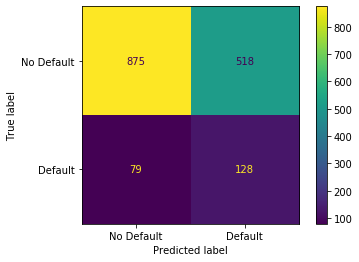

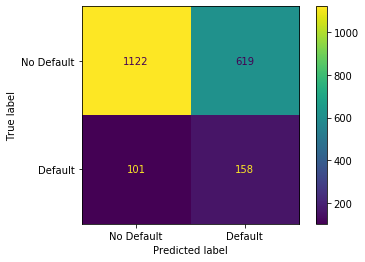

In [22]:
optimized_classifier = XGBClassifier(objective='binary:logistic',
                                     gamma=10.0,
                                     learning_rate=0.1,
                                     max_depth=3,
                                     reg_lambda=100.0,
                                     scale_pos_weight=7,
                                     use_label_encoder=False,
                                     subsample=0.95,
                                     colsample_bytree=0.5,
                                     seed=10)

model = optimized_classifier.fit(X_train,
                                 y_train,
                                 early_stopping_rounds=10,
                                 verbose=True,
                                 eval_metric='aucpr',
                                 eval_set=[(X_train, y_train), (X_val, y_val)])

plot_confusion_matrix(optimized_classifier,
                      X_val,
                      y_val,
                      values_format='d',
                      display_labels=["No Default",
                                      "Default"])

plot_confusion_matrix(optimized_classifier,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["No Default",
                                      "Default"])


In [23]:
# Model evaluation - Test-Validation Set
print('Validation Set Metrics: ')
print('-----------------------')
y_pred_val = optimized_classifier.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val)
accuracy = accuracy_score(y_val, y_pred_val)
print('Confusion matrix: \n', cm)
print('\nF1 Score: ', 2*cm[1, 1]/(2*cm[1, 1]+cm[0, 1]+cm[1, 0]))
print('\nPrecision: ', cm[1, 1]/(cm[1, 1]+cm[0, 1]))
print('\nAccuracy: ', accuracy)
print('\nRecall/Sensitivity: ', cm[1, 1]/(cm[1, 1]+cm[1, 0]))
print('\nSpecificity: ', cm[0, 0]/(cm[0, 0]+cm[0, 1]))

print('\n')
print('Test Set Metrics: ')
print('-----------------')
y_pred_test = optimized_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)
print('Confusion matrix: \n', cm)
print('\nF1 Score: ', 2*cm[1, 1]/(2*cm[1, 1]+cm[0, 1]+cm[1, 0]))
print('\nPrecision: ', cm[1, 1]/(cm[1, 1]+cm[0, 1]))
print('\nAccuracy: ', accuracy)
print('\nRecall/Sensitivity: ', cm[1, 1]/(cm[1, 1]+cm[1, 0]))
print('\nSpecificity: ', cm[0, 0]/(cm[0, 0]+cm[0, 1]))


Validation Set Metrics: 
-----------------------
Confusion matrix: 
 [[875 518]
 [ 79 128]]

F1 Score:  0.30011723329425555

Precision:  0.19814241486068113

Accuracy:  0.626875

Recall/Sensitivity:  0.6183574879227053

Specificity:  0.628140703517588


Test Set Metrics: 
-----------------
Confusion matrix: 
 [[1122  619]
 [ 101  158]]

F1 Score:  0.305019305019305

Precision:  0.20334620334620335

Accuracy:  0.64

Recall/Sensitivity:  0.61003861003861

Specificity:  0.6444572085008615
